In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load the car sales dataset
dataset_path = 'car details v4.csv'
car_data = pd.read_csv(dataset_path)

In [3]:
# Display first 5 rows of data
print("Dataset Preview:")
car_data.head()

Dataset Preview:


Make                            Model    Price  Year  Kilometer  \
0          Honda              Amaze 1.2 VX i-VTEC   505000  2017      87150   
1  Maruti Suzuki                  Swift DZire VDI   450000  2014      75000   
2        Hyundai             i10 Magna 1.2 Kappa2   220000  2011      67000   
3         Toyota                         Glanza G   799000  2019      37500   
4         Toyota  Innova 2.4 VX 7 STR [2016-2020]  1950000  2018      69000   

  Fuel Type Transmission   Location   Color   Owner Seller Type   Engine  \
0    Petrol       Manual       Pune    Grey   First   Corporate  1198 cc   
1    Diesel       Manual   Ludhiana   White  Second  Individual  1248 cc   
2    Petrol       Manual    Lucknow  Maroon   First  Individual  1197 cc   
3    Petrol       Manual  Mangalore     Red   First  Individual  1197 cc   
4    Diesel       Manual     Mumbai    Grey   First  Individual  2393 cc   

            Max Power              Max Torque Drivetrain  Length   Width  \
0   87 bhp @ 6000 rpm       109 Nm @ 4500 rpm        FWD  3990.0  1680.0   
1   74 bhp @ 4000 rpm       190 Nm @ 2000 rpm        FWD  3995.0  1695.0   
2   79 bhp @ 6000 rpm  112.7619 Nm @ 4000 rpm        FWD  3585.0  1595.0   
3   82 bhp @ 6000 rpm       113 Nm @ 4200 rpm        FWD  3995.0  1745.0   
4  148 bhp @ 3400 rpm       343 Nm @ 1400 rpm        RWD  4735.0  1830.0   

   Height  Seating Capacity  Fuel Tank Capacity  
0  1505.0               5.0                35.0  
1  1555.0               5.0                42.0  
2  1550.0               5.0                35.0  
3  1510.0               5.0                37.0  
4  1795.0               7.0                55.0

In [4]:
# Check for missing values
missing_values = car_data.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
Make                    0
Model                   0
Price                   0
Year                    0
Kilometer               0
Fuel Type               0
Transmission            0
Location                0
Color                   0
Owner                   0
Seller Type             0
Engine                 80
Max Power              80
Max Torque             80
Drivetrain            136
Length                 64
Width                  64
Height                 64
Seating Capacity       64
Fuel Tank Capacity    113
dtype: int64


In [5]:
def remove_cc_from_engine(data):
    """
    Remove 'cc' from the values in the 'Engine' column.
    """
    data['Engine'] = data['Engine'].str.replace(' cc', '').astype(float)
    return data
car_data = remove_cc_from_engine(car_data)

In [6]:
def extract_max_power(data):
    """
    Extract numerical values from the 'Max Power' column and create separate columns for 'BHP' and 'RPM'.
    """
    # Extract numerical values for BHP and RPM
    data[['Max Power BHP', 'Max Power RPM']] = data['Max Power'].str.extract(r'(\d+\.?\d*) bhp @ (\d+) rpm')

    # Convert columns to numeric
    data[['Max Power BHP', 'Max Power RPM']] = data[['Max Power BHP', 'Max Power RPM']].apply(pd.to_numeric)

    # Drop the original 'Max Power' column
    data.drop('Max Power', axis=1, inplace=True)

    return data
car_data = extract_max_power(car_data)

In [7]:
def extract_max_torque(data):
    """
    Extract numerical values from the 'Max Torque' column and create separate columns for 'Torque' and 'RPM'.
    """
    # Extract numerical values for Torque and RPM
    data[['Max Torque Nm', 'Max Torque RPM']] = data['Max Torque'].str.extract(r'(\d+\.?\d*) Nm @ (\d+) rpm')

    # Convert columns to numeric
    data[['Max Torque Nm', 'Max Torque RPM']] = data[['Max Torque Nm', 'Max Torque RPM']].apply(pd.to_numeric)

    # Drop the original 'Max Torque' column
    data.drop('Max Torque', axis=1, inplace=True)

    return data
car_data = extract_max_torque(car_data)

In [8]:
# Display first 5 rows of data
print("Dataset Preview:")
car_data.head()

Dataset Preview:


Make                            Model    Price  Year  Kilometer  \
0          Honda              Amaze 1.2 VX i-VTEC   505000  2017      87150   
1  Maruti Suzuki                  Swift DZire VDI   450000  2014      75000   
2        Hyundai             i10 Magna 1.2 Kappa2   220000  2011      67000   
3         Toyota                         Glanza G   799000  2019      37500   
4         Toyota  Innova 2.4 VX 7 STR [2016-2020]  1950000  2018      69000   

  Fuel Type Transmission   Location   Color   Owner  ... Drivetrain  Length  \
0    Petrol       Manual       Pune    Grey   First  ...        FWD  3990.0   
1    Diesel       Manual   Ludhiana   White  Second  ...        FWD  3995.0   
2    Petrol       Manual    Lucknow  Maroon   First  ...        FWD  3585.0   
3    Petrol       Manual  Mangalore     Red   First  ...        FWD  3995.0   
4    Diesel       Manual     Mumbai    Grey   First  ...        RWD  4735.0   

    Width  Height  Seating Capacity  Fuel Tank Capacity  Max Power BHP  \
0  1680.0  1505.0               5.0                35.0           87.0   
1  1695.0  1555.0               5.0                42.0           74.0   
2  1595.0  1550.0               5.0                35.0           79.0   
3  1745.0  1510.0               5.0                37.0           82.0   
4  1830.0  1795.0               7.0                55.0          148.0   

   Max Power RPM  Max Torque Nm  Max Torque RPM  
0         6000.0       109.0000          4500.0  
1         4000.0       190.0000          2000.0  
2         6000.0       112.7619          4000.0  
3         6000.0       113.0000          4200.0  
4         3400.0       343.0000          1400.0  

[5 rows x 22 columns]

In [9]:
car_data.columns

Index(['Make', 'Model', 'Price', 'Year', 'Kilometer', 'Fuel Type',
       'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Engine',
       'Drivetrain', 'Length', 'Width', 'Height', 'Seating Capacity',
       'Fuel Tank Capacity', 'Max Power BHP', 'Max Power RPM', 'Max Torque Nm',
       'Max Torque RPM'],
      dtype='object')

In [10]:
# Handle missing values using SimpleImputer and using mean as the strategy
imputer = SimpleImputer(strategy='mean')
numerical_features = ['Price', 'Kilometer', 'Engine', 'Max Power BHP', 'Max Power RPM', 'Max Torque Nm', 'Max Torque RPM', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']
car_data[numerical_features] = imputer.fit_transform(car_data[numerical_features])

In [11]:
categorical_features = ['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Drivetrain']

In [12]:
# Filling missing values with mode
for feature in categorical_features:
        car_data[feature].fillna(car_data[feature].mode()[0], inplace=True)

In [13]:
# Check for missing values
missing_values = car_data.isnull().sum()
print("\nMissing Values:")
print(missing_values)
print("Now we have handled all the missing values.")


Missing Values:
Make                  0
Model                 0
Price                 0
Year                  0
Kilometer             0
Fuel Type             0
Transmission          0
Location              0
Color                 0
Owner                 0
Seller Type           0
Engine                0
Drivetrain            0
Length                0
Width                 0
Height                0
Seating Capacity      0
Fuel Tank Capacity    0
Max Power BHP         0
Max Power RPM         0
Max Torque Nm         0
Max Torque RPM        0
dtype: int64
Now we have handled all the missing values.


In [14]:
# Normalize numerical features using StandardScaler
scaler = StandardScaler()
car_data[numerical_features] = scaler.fit_transform(car_data[numerical_features])

In [15]:
# Exploratory Data Analysis (EDA)
# Visualize data to gain insights
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

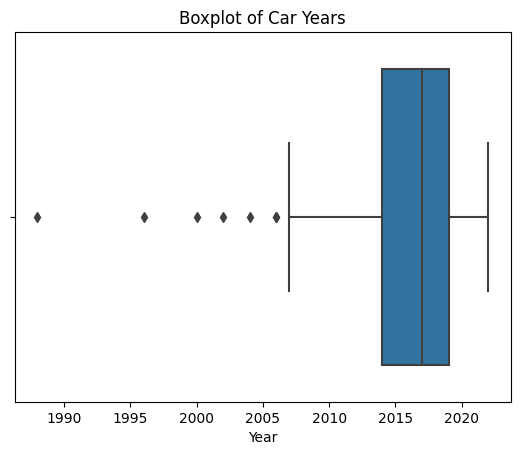

In [16]:
# Boxplot to identify outliers
sns.boxplot(x='Year', data=car_data)
plt.title('Boxplot of Car Years')
plt.show()

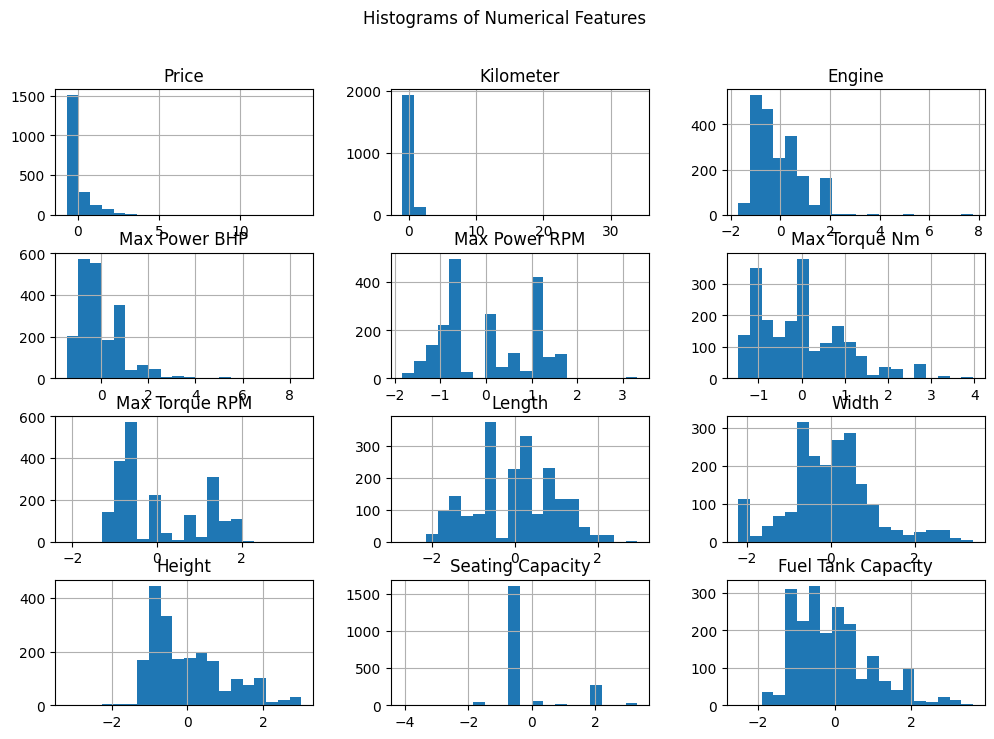

In [17]:
# Histograms for numerical features
car_data[numerical_features].hist(bins=20, figsize=(12, 8))
plt.suptitle('Histograms of Numerical Features')
plt.show()

In [18]:
# Descriptive statistics
statistics = car_data.describe()
print("\nDescriptive Statistics:")
print(statistics)


Descriptive Statistics:
              Price         Year     Kilometer        Engine        Length  \
count  2.059000e+03  2059.000000  2.059000e+03  2.059000e+03  2.059000e+03   
mean  -5.521459e-17  2016.425449 -4.486185e-17  2.139565e-16  1.621929e-15   
std    1.000243e+00     3.363564  1.000243e+00  1.000243e+00  1.000243e+00   
min   -6.836674e-01  1988.000000 -9.455415e-01 -1.693606e+00 -2.714309e+00   
25%   -5.034499e-01  2014.000000 -4.398550e-01 -7.838621e-01 -6.771890e-01   
50%   -3.629125e-01  2017.000000 -7.366830e-02 -3.083864e-01  7.840582e-02   
75%    9.176578e-02  2019.000000  3.099559e-01  4.793182e-01  7.788812e-01   
max    1.376312e+01  2022.000000  3.392939e+01  7.765190e+00  2.958393e+00   

              Width        Height  Seating Capacity  Fuel Tank Capacity  \
count  2.059000e+03  2.059000e+03      2.059000e+03        2.059000e+03   
mean  -8.903352e-16 -1.593459e-15     -2.001529e-16        1.967020e-16   
std    1.000243e+00  1.000243e+00      1.000243

In [19]:
# Addressing outliers and removing them
def remove_outliers_iqr(data, feature):
    """
    Remove outliers from a specific feature using IQR.
    """
    # Calculate IQR
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define upper and lower bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]

    return data

In [20]:
for feature in numerical_features:
        car_data = remove_outliers_iqr(car_data, feature)

In [21]:
# Save the preprocessed dataset to a new CSV file
car_data.to_csv('preprocessed_car_data.csv', index=False)

In [22]:
preprocessed_car_data = pd.read_csv('preprocessed_car_data.csv')
preprocessed_car_data.head()

Make                 Model     Price  Year  Kilometer Fuel Type  \
0          Honda   Amaze 1.2 VX i-VTEC -0.495183  2017   0.574133    Petrol   
1  Maruti Suzuki       Swift DZire VDI -0.517916  2014   0.362268    Diesel   
2        Hyundai  i10 Magna 1.2 Kappa2 -0.612986  2011   0.222769    Petrol   
3         Toyota              Glanza G -0.373659  2019  -0.291637    Petrol   
4  Maruti Suzuki              Ciaz ZXi -0.424914  2017   0.332886    Petrol   

  Transmission   Location   Color   Owner  ... Drivetrain    Length     Width  \
0       Manual       Pune    Grey   First  ...        FWD -0.668002 -0.661029   
1       Manual   Ludhiana   White  Second  ...        FWD -0.656519 -0.548343   
2       Manual    Lucknow  Maroon   First  ...        FWD -1.598142 -1.299581   
3       Manual  Mangalore     Red   First  ...        FWD -0.656519 -0.172724   
4       Manual       Pune    Grey   First  ...        FWD  0.480318 -0.285410   

     Height  Seating Capacity  Fuel Tank Capacity  Max Power BHP  \
0 -0.647719         -0.378532           -1.157720      -0.707811   
1 -0.274331         -0.378532           -0.681074      -0.916825   
2 -0.311670         -0.378532           -1.157720      -0.836435   
3 -0.610380         -0.378532           -1.021535      -0.788201   
4 -0.797074         -0.378532           -0.612981      -0.643500   

   Max Power RPM  Max Torque Nm  Max Torque RPM  
0       1.148534      -1.052682        1.667664  
1      -0.779048      -0.445979       -0.516990  
2       1.148534      -1.024505        1.230733  
3       1.148534      -1.022721        1.405506  
4       1.148534      -0.895389        1.230733  

[5 rows x 22 columns]

In [23]:
preprocessed_car_data.describe()

Price         Year    Kilometer       Engine       Length  \
count  1236.000000  1236.000000  1236.000000  1236.000000  1236.000000   
mean     -0.321107  2016.478964    -0.063290    -0.413748    -0.313915   
std       0.299879     3.030540     0.456675     0.513746     0.773428   
min      -0.656387  2006.000000    -0.935079    -1.425754    -1.956418   
25%      -0.517916  2014.000000    -0.404980    -0.785447    -0.722548   
50%      -0.429874  2017.000000    -0.073668    -0.489067    -0.653074   
75%      -0.239529  2019.000000     0.267339    -0.160989     0.319553   
max       0.945321  2022.000000     1.368113     1.274947     1.536773   

             Width       Height  Seating Capacity  Fuel Tank Capacity  \
count  1236.000000  1236.000000      1.236000e+03         1236.000000   
mean     -0.285744    -0.386323     -3.785317e-01           -0.407629   
std       0.569494     0.554275      5.553362e-17            0.638810   
min      -1.863010    -1.655867     -3.785317e-01           -1.702459   
25%      -0.555856    -0.797074     -3.785317e-01           -0.817258   
50%      -0.285410    -0.535703     -3.785317e-01           -0.544889   
75%       0.165333     0.099057     -3.785317e-01           -0.068243   
max       1.495024     1.256561     -3.785317e-01            1.225512   

       Max Power BHP  Max Power RPM  Max Torque Nm  Max Torque RPM  
count    1236.000000    1236.000000    1236.000000     1236.000000  
mean       -0.362917       0.227938      -0.408689        0.275853  
std         0.556309       0.993144       0.659460        1.068079  
min        -1.367009      -1.742838      -1.329818       -2.133634  
25%        -0.788201      -0.779048      -1.015231       -0.735455  
50%        -0.514876       0.281122      -0.543351        0.000000  
75%         0.000000       1.148534       0.003431        1.230733  
max         1.350170       1.726808       1.426561        2.104595

In [24]:
preprocessed_car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                1236 non-null   object 
 1   Model               1236 non-null   object 
 2   Price               1236 non-null   float64
 3   Year                1236 non-null   int64  
 4   Kilometer           1236 non-null   float64
 5   Fuel Type           1236 non-null   object 
 6   Transmission        1236 non-null   object 
 7   Location            1236 non-null   object 
 8   Color               1236 non-null   object 
 9   Owner               1236 non-null   object 
 10  Seller Type         1236 non-null   object 
 11  Engine              1236 non-null   float64
 12  Drivetrain          1236 non-null   object 
 13  Length              1236 non-null   float64
 14  Width               1236 non-null   float64
 15  Height              1236 non-null   float64
 16  Seatin

UniVariate Analysis: 


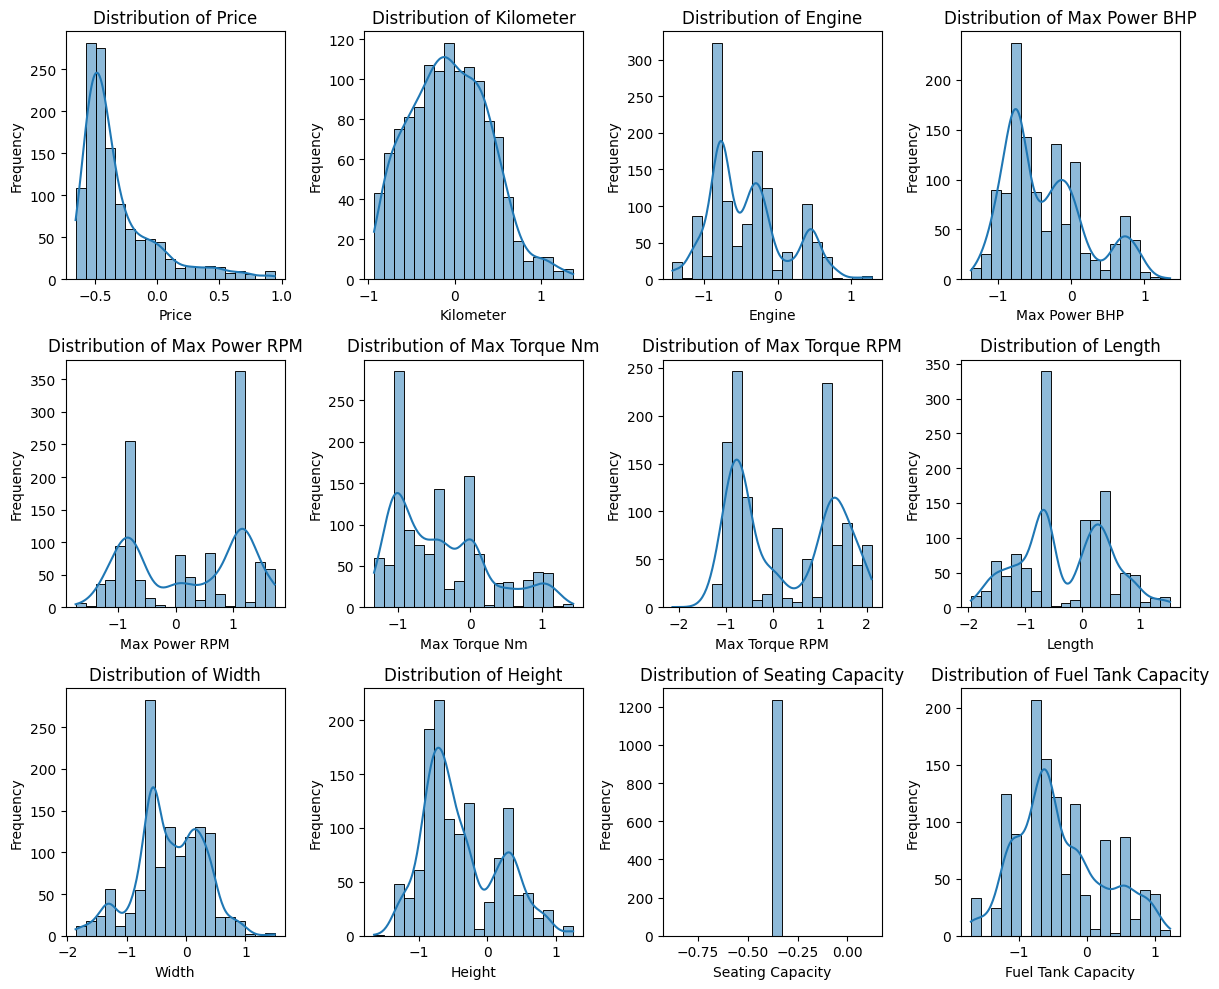

In [25]:
# 2. Exploratory Data Analysis (EDA)

# Univariate Analysis
print("UniVariate Analysis: ")
plt.figure(figsize=(12, 10))
for feature in numerical_features:
    plt.subplot(3, 4, numerical_features.index(feature)+1)
    sns.histplot(car_data[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

BiVariate Analysis: 


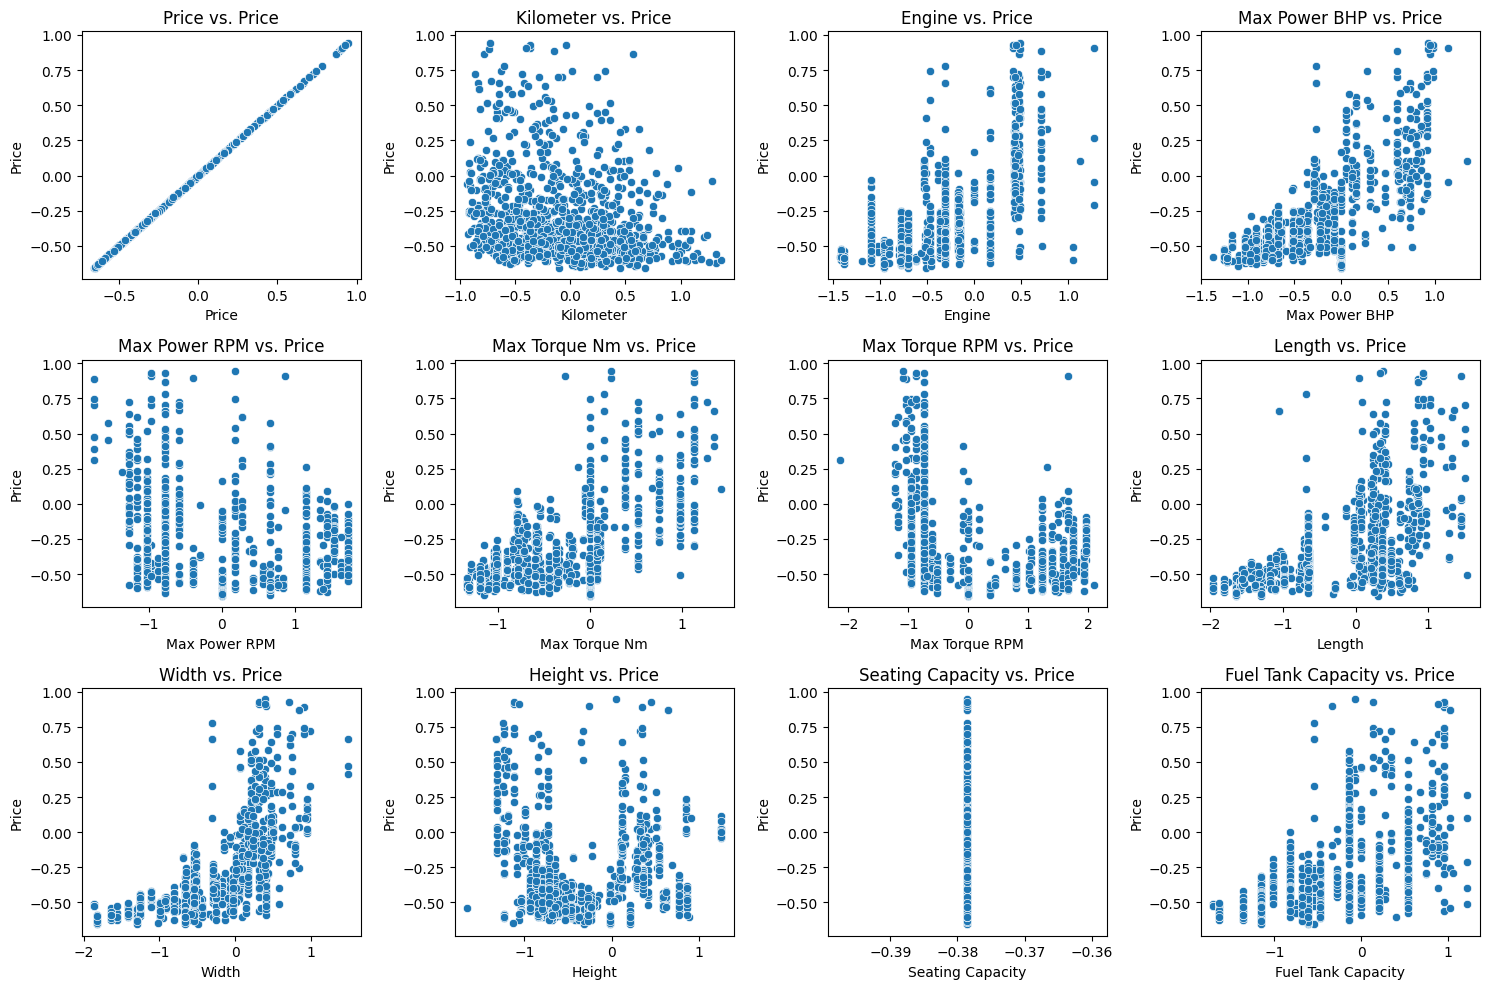

In [26]:
print("BiVariate Analysis: ")
# Bivariate Analysis
plt.figure(figsize=(15, 10))
for feature in numerical_features:
    plt.subplot(3, 4, numerical_features.index(feature)+1)
    sns.scatterplot(x=car_data[feature], y=car_data['Price'])
    plt.title(f'{feature} vs. Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [27]:
# Feature Engineering
def convert_categorical_to_numerical(data, categorical_features):
    """
    Convert categorical variables into numerical representations.
    """
    for feature in categorical_features:
        data[feature] = LabelEncoder().fit_transform(data[feature])

    return data

preprocessed_car_data = convert_categorical_to_numerical(preprocessed_car_data, categorical_features)

In [28]:
car_data.head()

Make                 Model     Price  Year  Kilometer Fuel Type  \
0          Honda   Amaze 1.2 VX i-VTEC -0.495183  2017   0.574133    Petrol   
1  Maruti Suzuki       Swift DZire VDI -0.517916  2014   0.362268    Diesel   
2        Hyundai  i10 Magna 1.2 Kappa2 -0.612986  2011   0.222769    Petrol   
3         Toyota              Glanza G -0.373659  2019  -0.291637    Petrol   
5  Maruti Suzuki              Ciaz ZXi -0.424914  2017   0.332886    Petrol   

  Transmission   Location   Color   Owner  ... Drivetrain    Length     Width  \
0       Manual       Pune    Grey   First  ...        FWD -0.668002 -0.661029   
1       Manual   Ludhiana   White  Second  ...        FWD -0.656519 -0.548343   
2       Manual    Lucknow  Maroon   First  ...        FWD -1.598142 -1.299581   
3       Manual  Mangalore     Red   First  ...        FWD -0.656519 -0.172724   
5       Manual       Pune    Grey   First  ...        FWD  0.480318 -0.285410   

     Height  Seating Capacity  Fuel Tank Capacity  Max Power BHP  \
0 -0.647719         -0.378532           -1.157720      -0.707811   
1 -0.274331         -0.378532           -0.681074      -0.916825   
2 -0.311670         -0.378532           -1.157720      -0.836435   
3 -0.610380         -0.378532           -1.021535      -0.788201   
5 -0.797074         -0.378532           -0.612981      -0.643500   

   Max Power RPM  Max Torque Nm  Max Torque RPM  
0       1.148534      -1.052682        1.667664  
1      -0.779048      -0.445979       -0.516990  
2       1.148534      -1.024505        1.230733  
3       1.148534      -1.022721        1.405506  
5       1.148534      -0.895389        1.230733  

[5 rows x 22 columns]

In [29]:
def conduct_hypothesis_tests(data, numerical_features):
    """
    Conduct hypothesis tests to evaluate the significance of variables.
    """
    for feature in numerical_features:
        stat, p_value = ttest_ind(data[data['Drivetrain'] == 0][feature], data[data['Drivetrain'] == 1][feature])
        print(f'Test for {feature} - p-value: {p_value}')

conduct_hypothesis_tests(preprocessed_car_data, numerical_features)

Test for Price - p-value: 1.7395083029790343e-45
Test for Kilometer - p-value: 0.0036324412786053447
Test for Engine - p-value: 2.6418188898677117e-43
Test for Max Power BHP - p-value: 1.6049767213179643e-53
Test for Max Power RPM - p-value: 3.5331672879699136e-14
Test for Max Torque Nm - p-value: 9.02295173767716e-58
Test for Max Torque RPM - p-value: 1.4493207299384154e-11
Test for Length - p-value: 9.008195771997371e-12
Test for Width - p-value: 1.513265351556402e-26
Test for Height - p-value: 3.8392107011242726e-14
Test for Seating Capacity - p-value: 5.373662115050393e-37
Test for Fuel Tank Capacity - p-value: 2.5109752613076e-41


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


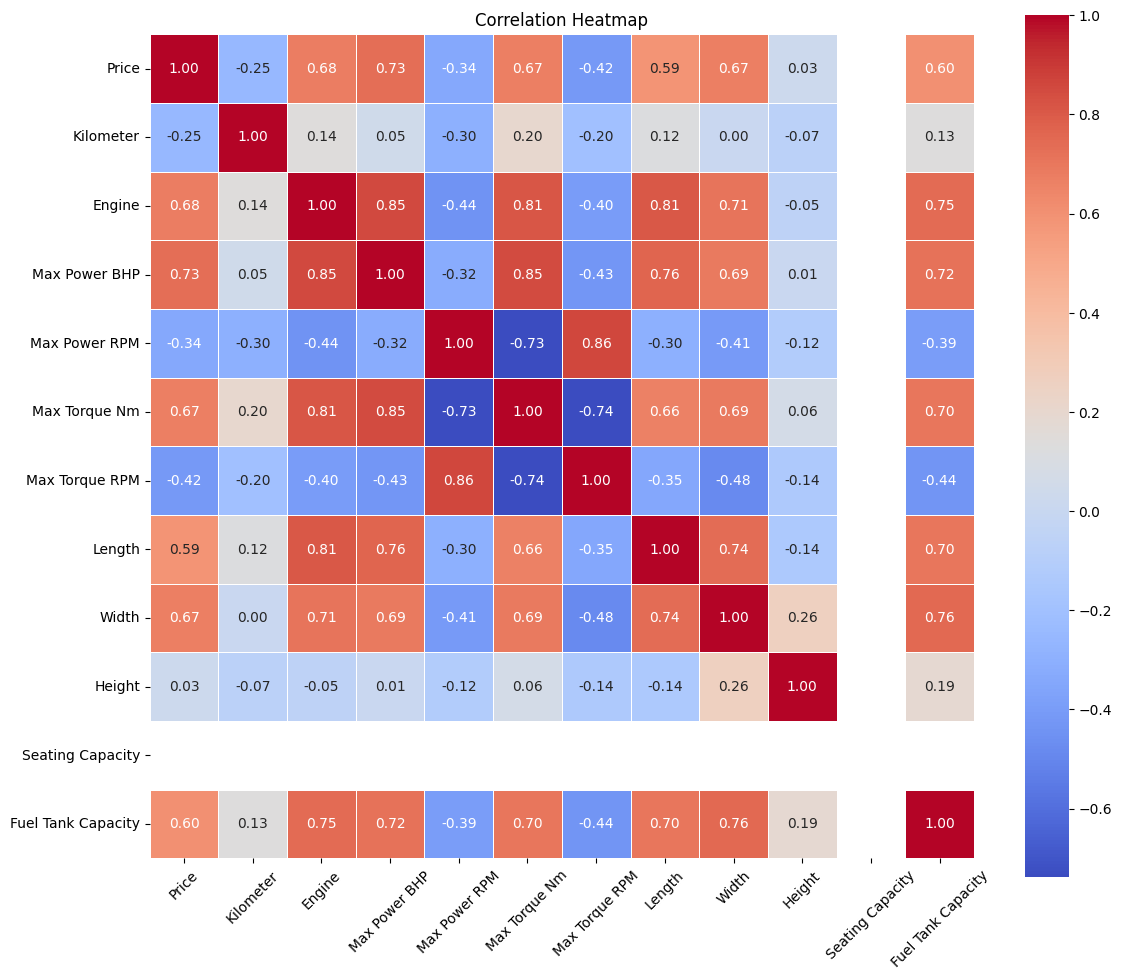

In [30]:
# Display correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(preprocessed_car_data[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
#Data Visualizations

In [32]:
#ANOVA test
# Selecting the relevant columns for ANOVA
anova_data = preprocessed_car_data[['Fuel Type', 'Price']]

In [33]:
# Performing ANOVA test
fuel_types = anova_data['Fuel Type'].unique()
anova_results = {fuel_type: anova_data[anova_data['Fuel Type'] == fuel_type]['Price'] for fuel_type in fuel_types}

In [34]:
# Performing the ANOVA test
f_statistic, p_value = f_oneway(*anova_results.values())

In [35]:
# Displaying the results
print(f'ANOVA Results:')
print(f'F-Statistic: {f_statistic}')
print(f'P-Value: {p_value}')

ANOVA Results:
F-Statistic: 25.81684878333002
P-Value: 7.63128909245819e-25


In [36]:
# Checking the significance level
alpha = 0.05
if p_value < alpha:
    print('The difference in means is statistically significant. Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis. There is no significant difference in means.')

The difference in means is statistically significant. Reject the null hypothesis.


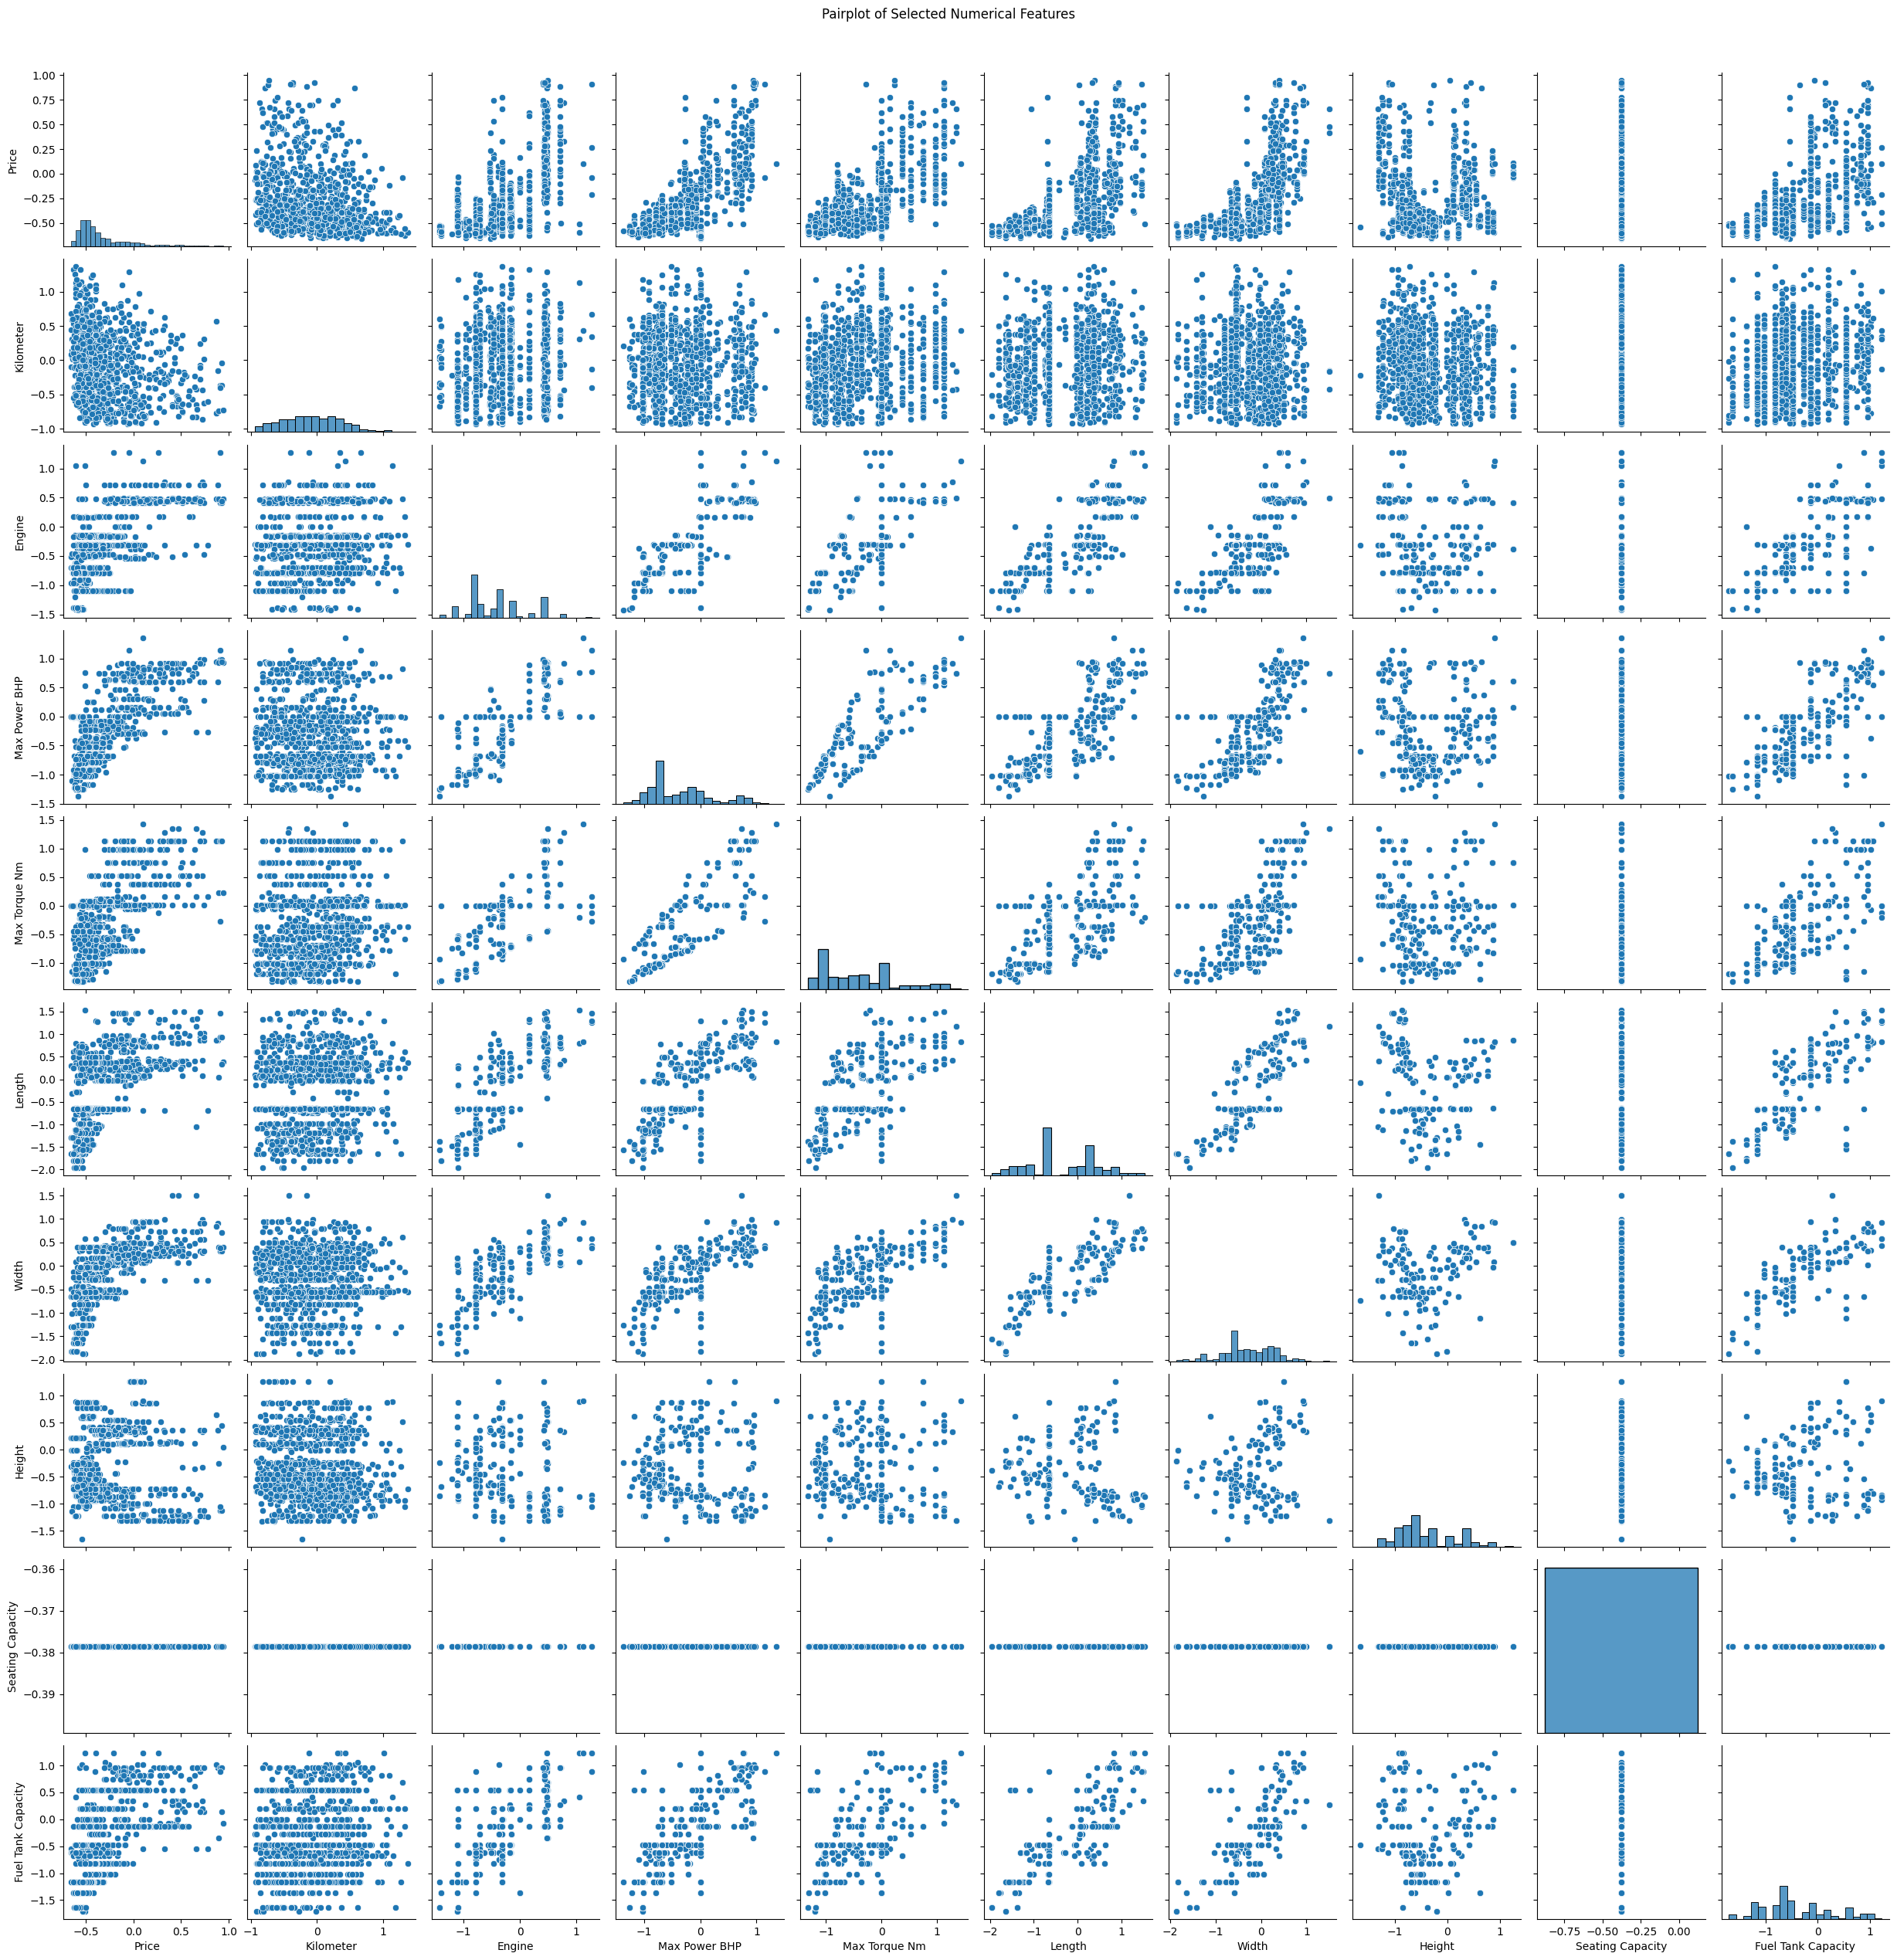

In [37]:
# Pairplot for selected numerical features
numerical_features = ['Price', 'Kilometer', 'Engine', 'Max Power BHP', 'Max Torque Nm', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']
selected_data = preprocessed_car_data[numerical_features]
sns.pairplot(selected_data)
plt.suptitle('Pairplot of Selected Numerical Features', y=1.02)
plt.show()

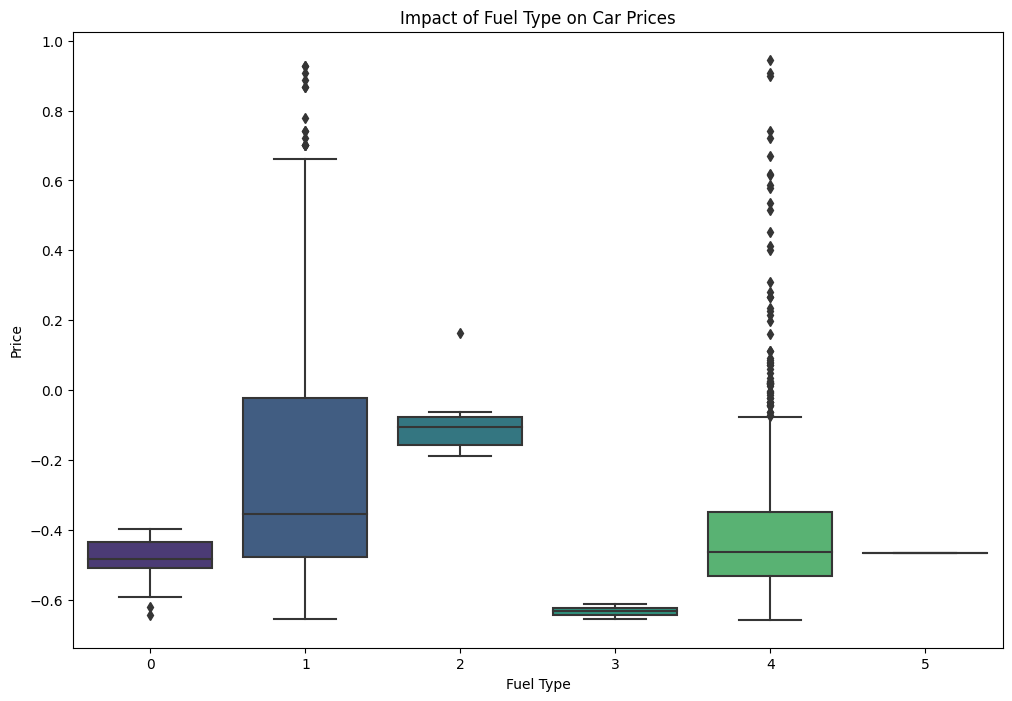

In [38]:
# Boxplot of 'Fuel Type' vs 'Price'
plt.figure(figsize=(12, 8))
sns.boxplot(x='Fuel Type', y='Price', data=preprocessed_car_data, palette='viridis')
plt.title('Impact of Fuel Type on Car Prices')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

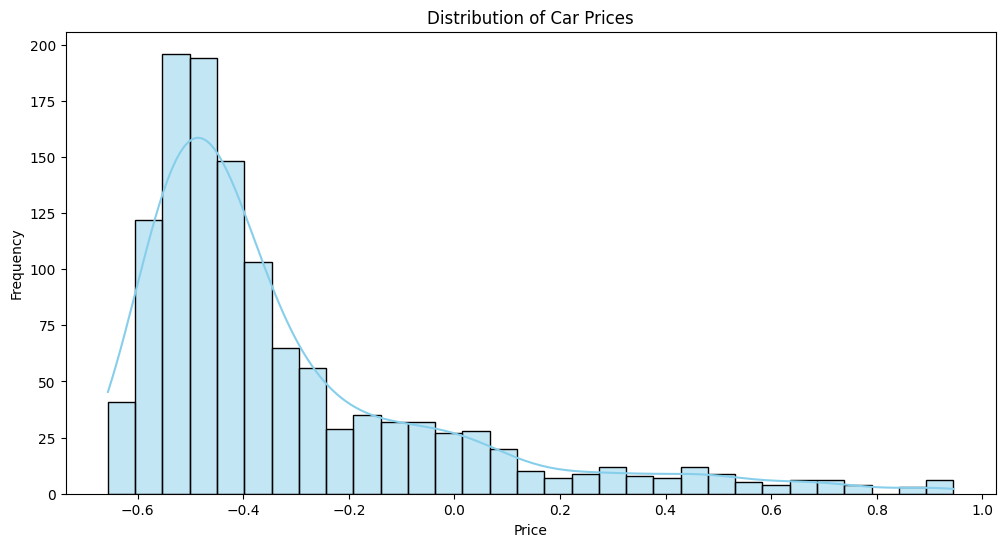

In [39]:
# Distribution of 'Price'
plt.figure(figsize=(12, 6))
sns.histplot(preprocessed_car_data['Price'], kde=True, color='skyblue')
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [40]:
# Analysis of relevant features
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

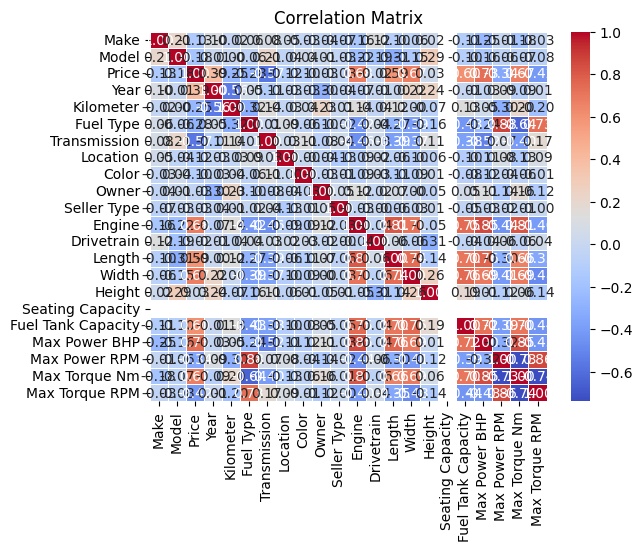

In [74]:
# Correlation matrix
correlation_matrix = preprocessed_car_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

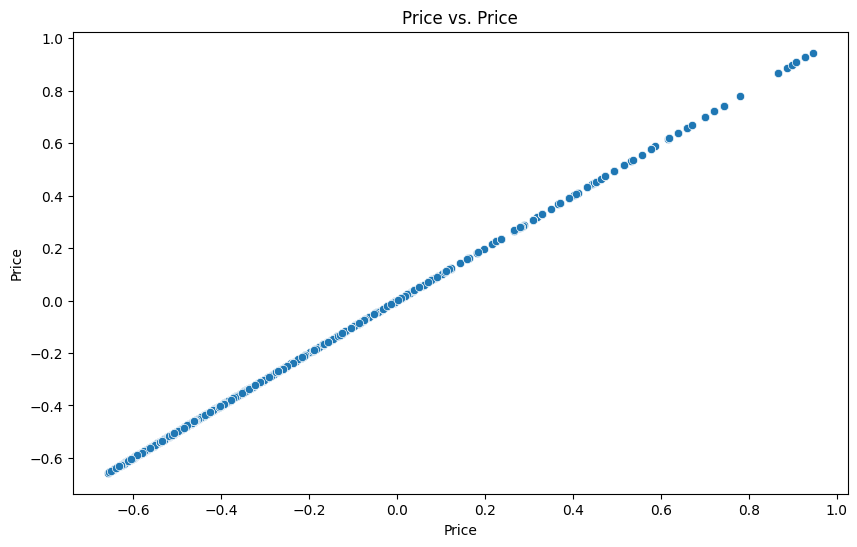

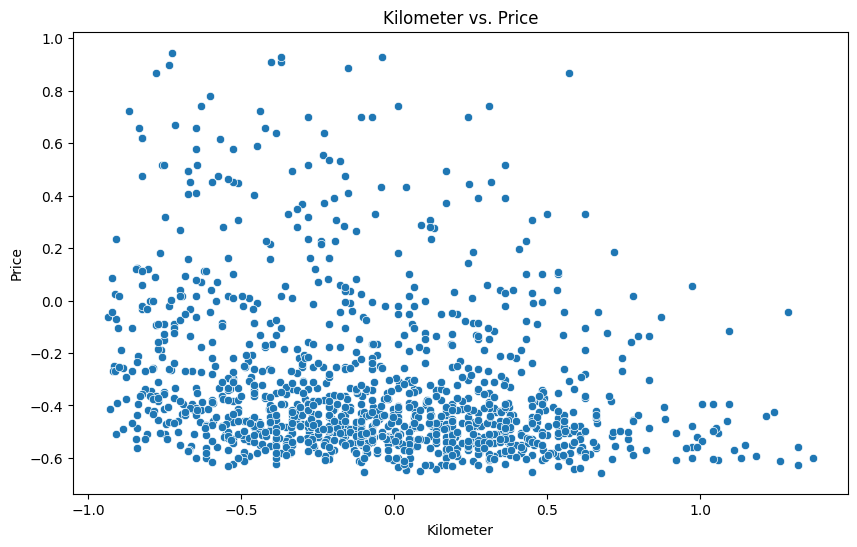

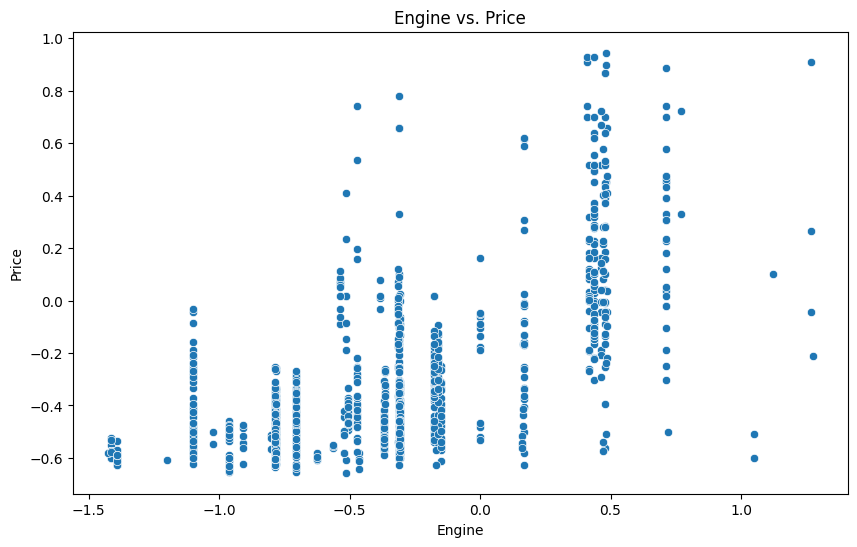

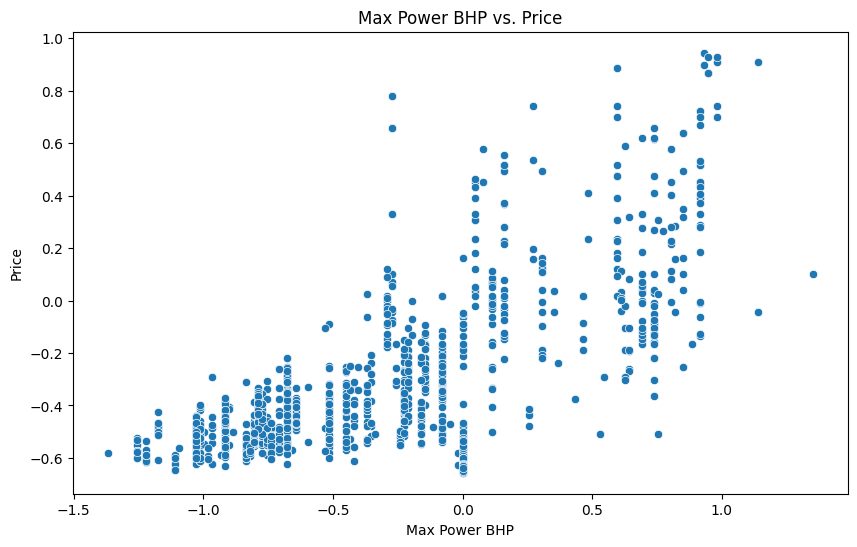

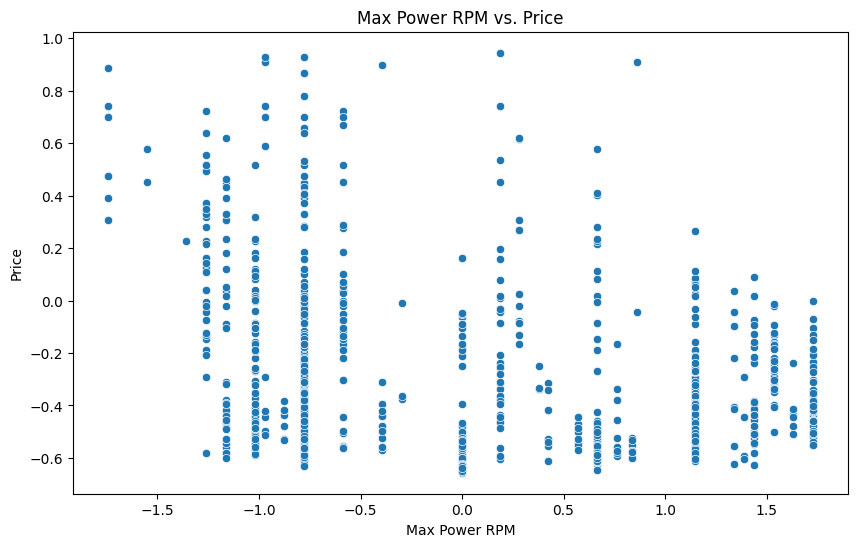

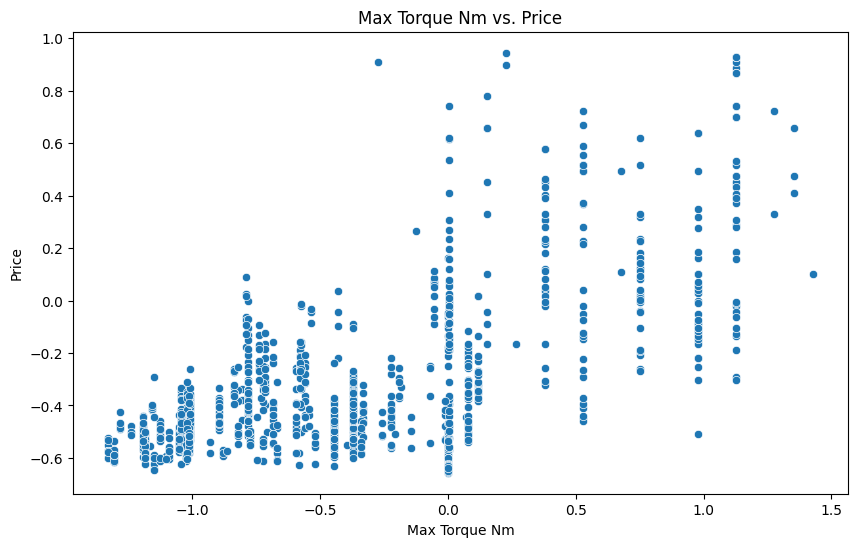

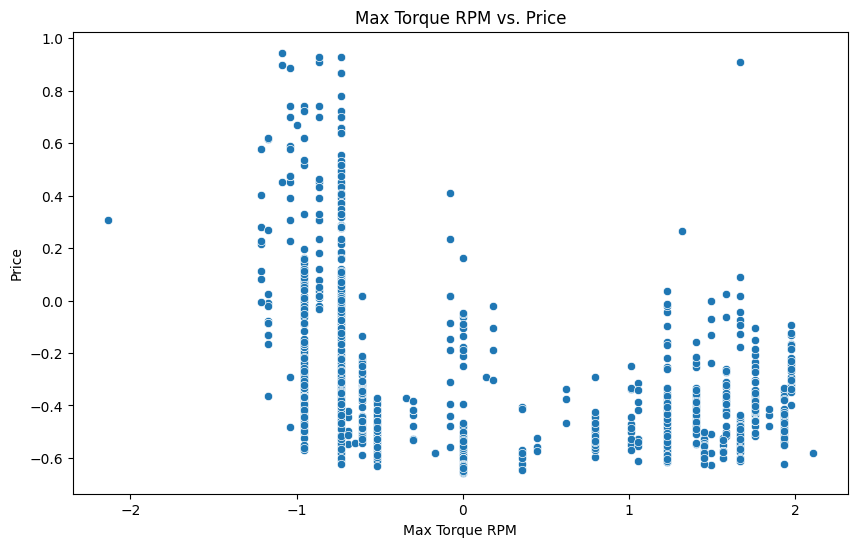

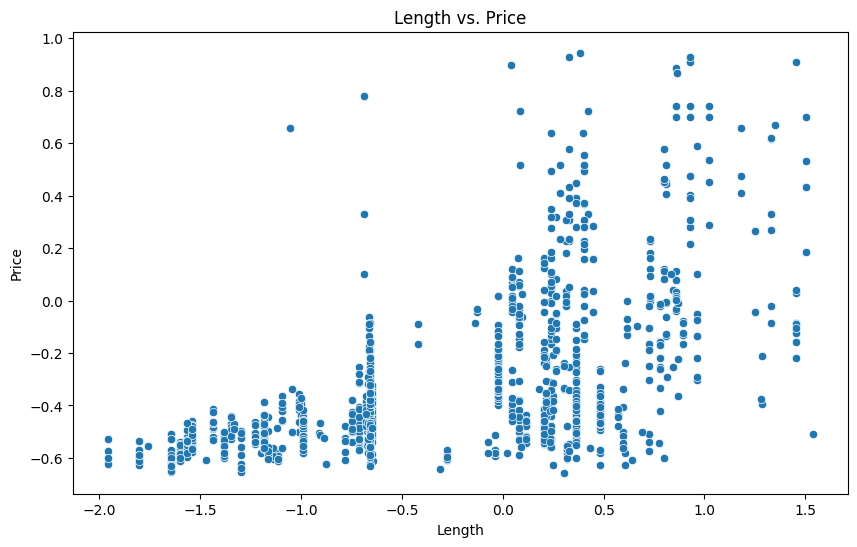

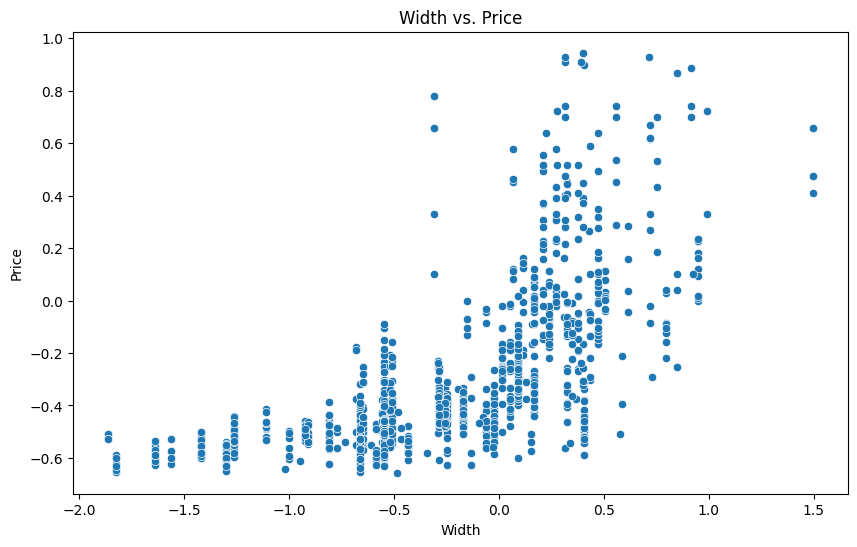

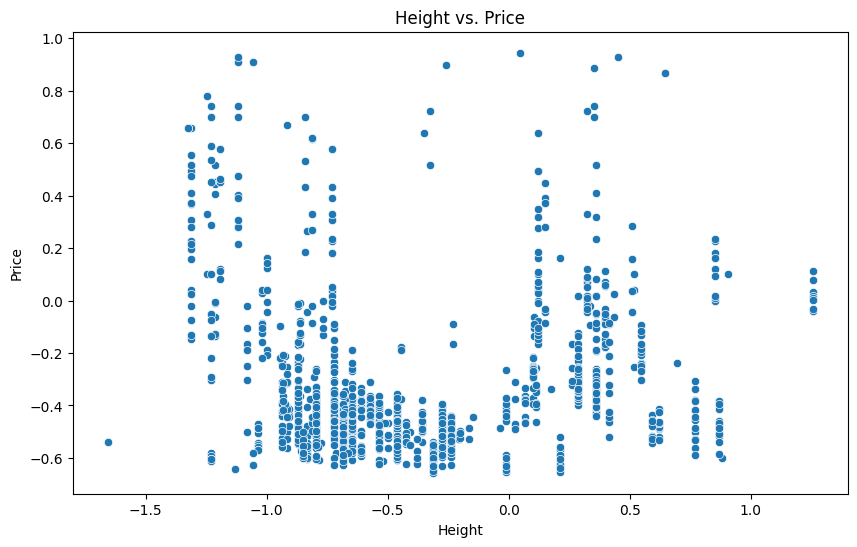

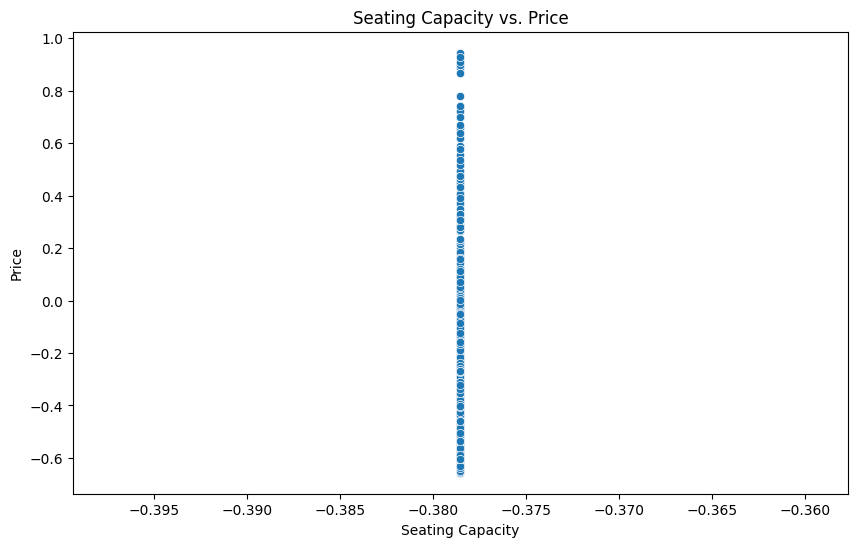

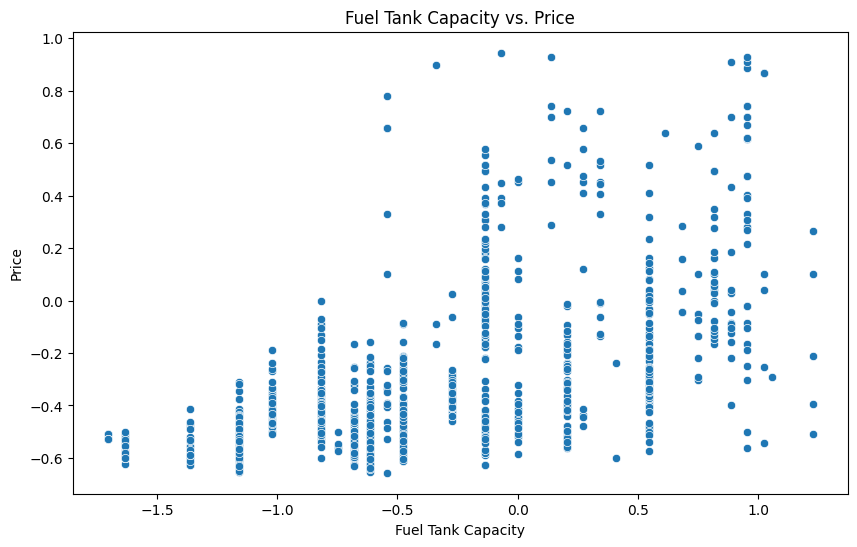

In [42]:
# Scatter plots for numeric features vs. Price
numeric_features = ['Price', 'Kilometer', 'Engine', 'Max Power BHP', 'Max Power RPM', 'Max Torque Nm', 'Max Torque RPM', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=preprocessed_car_data, x=feature, y='Price')
    plt.title(f'{feature} vs. Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

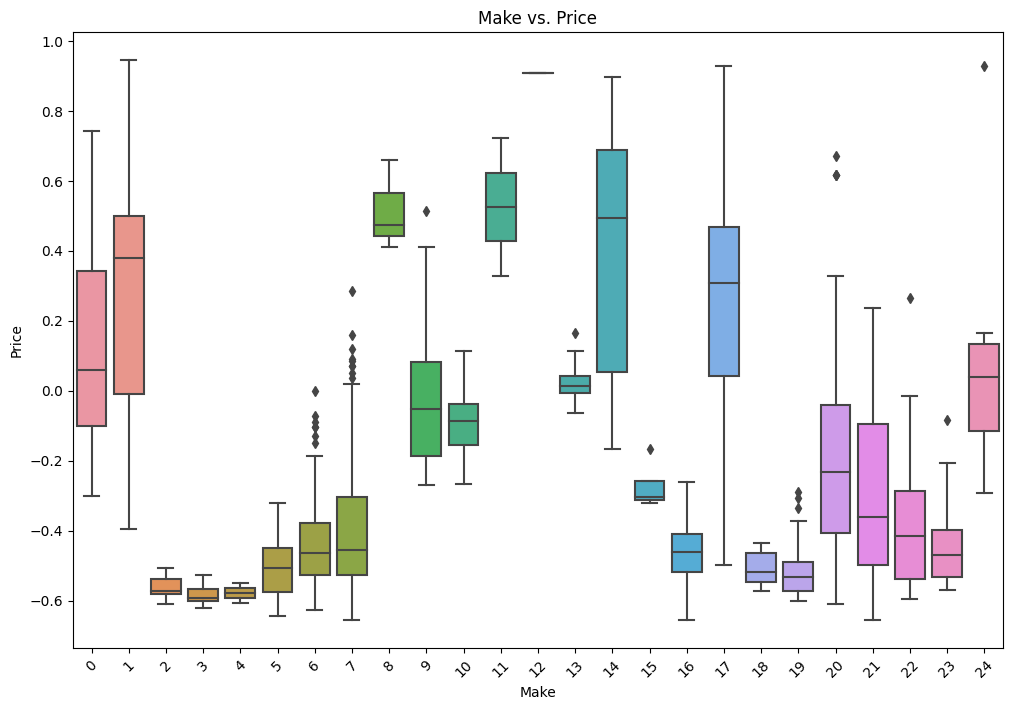

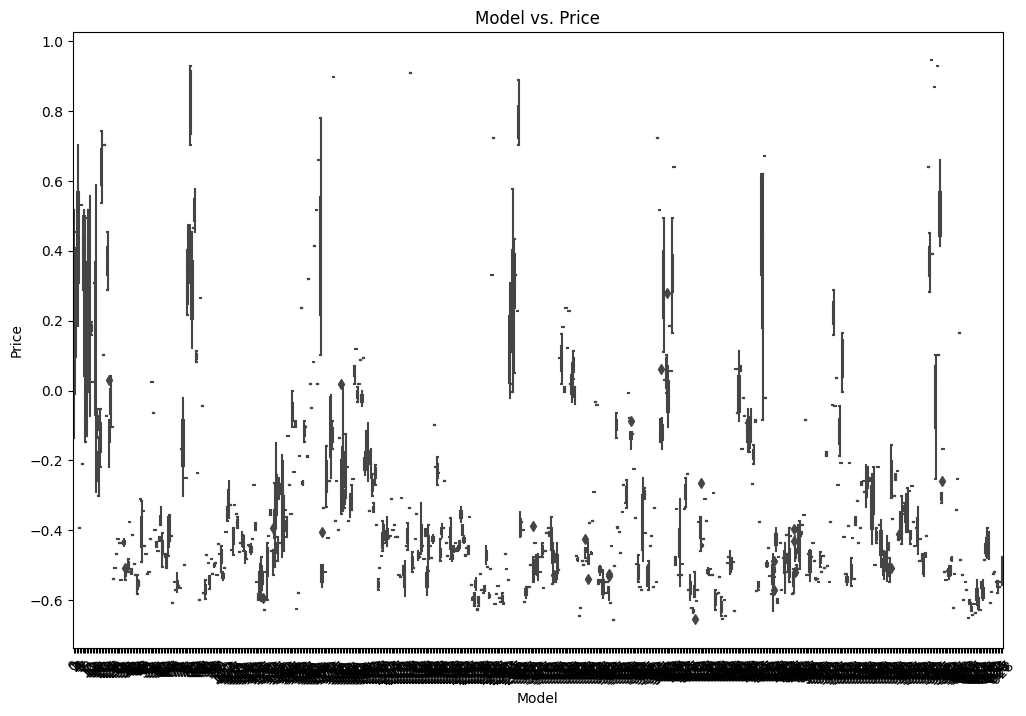

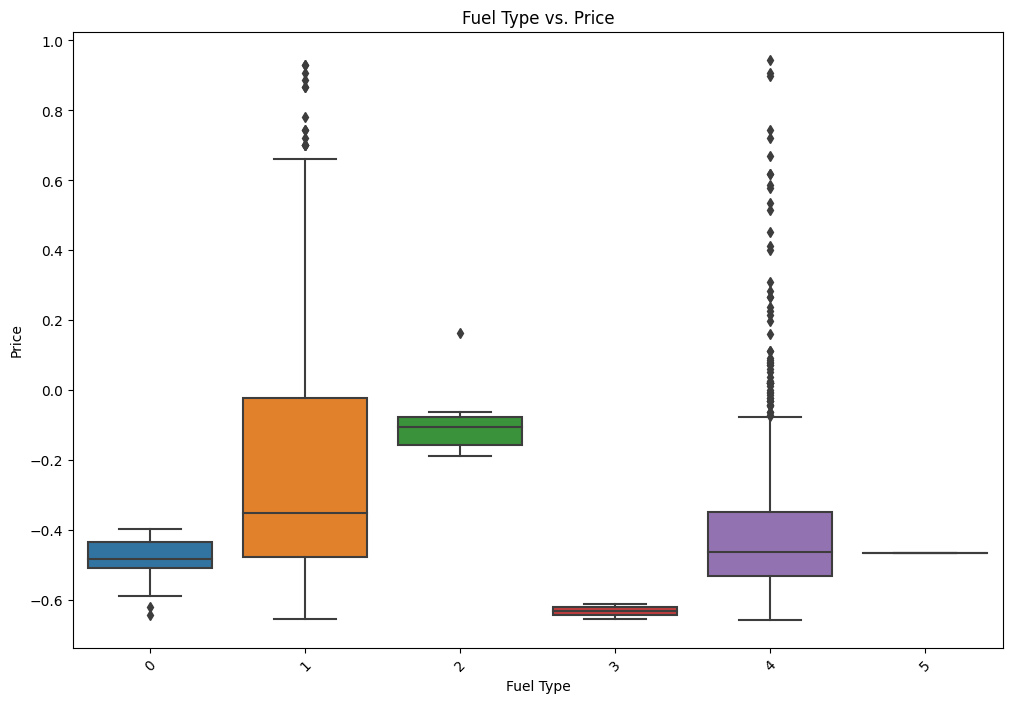

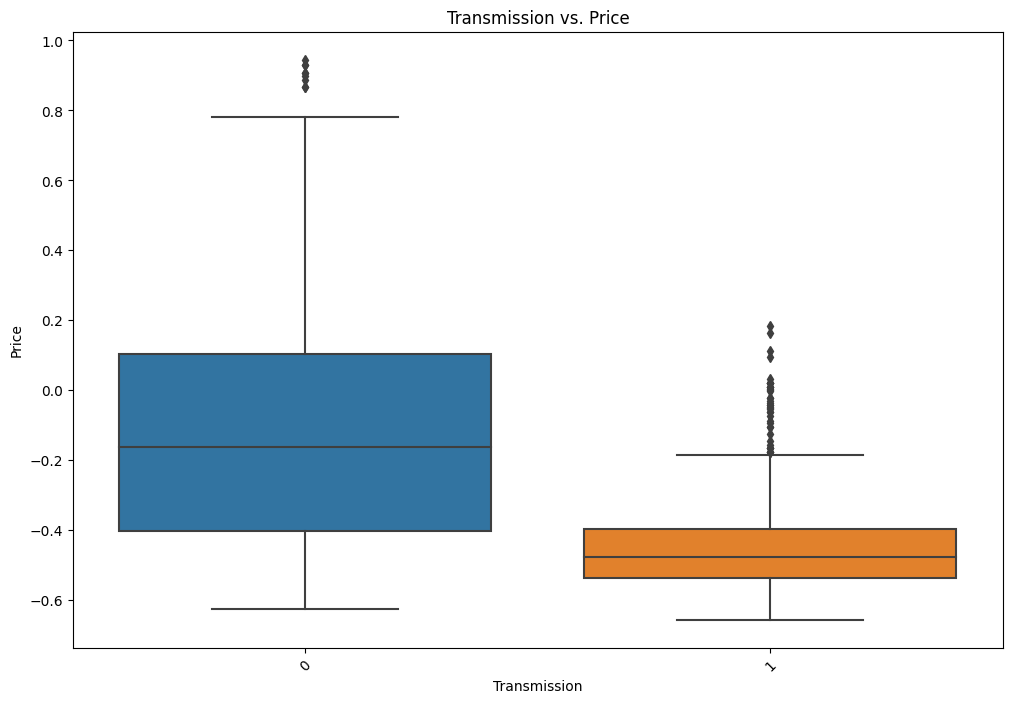

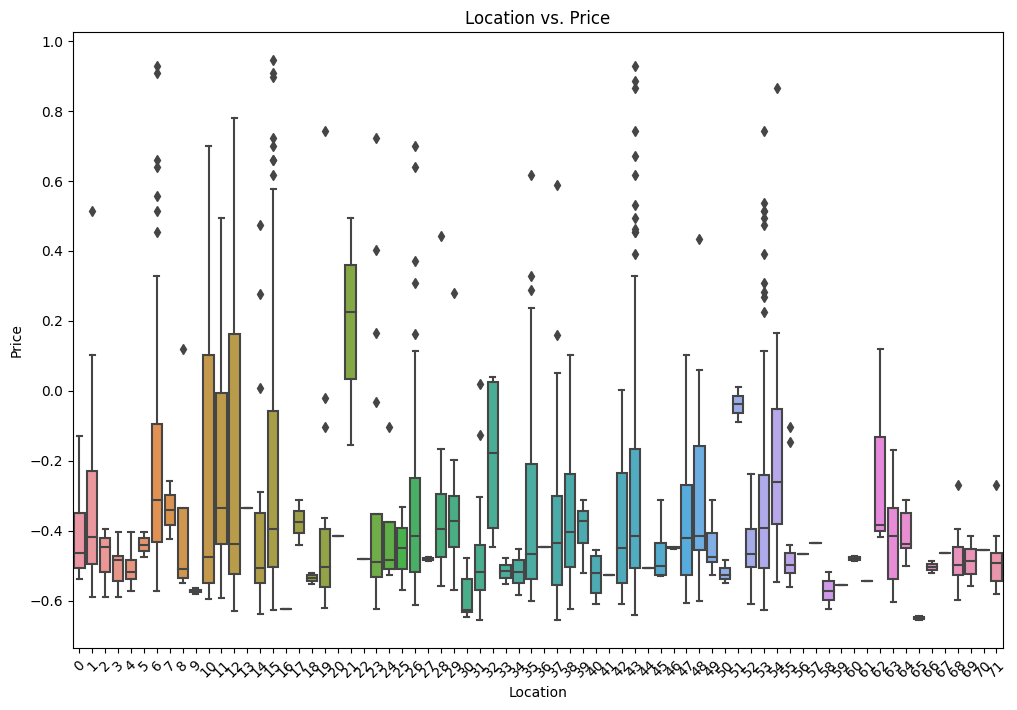

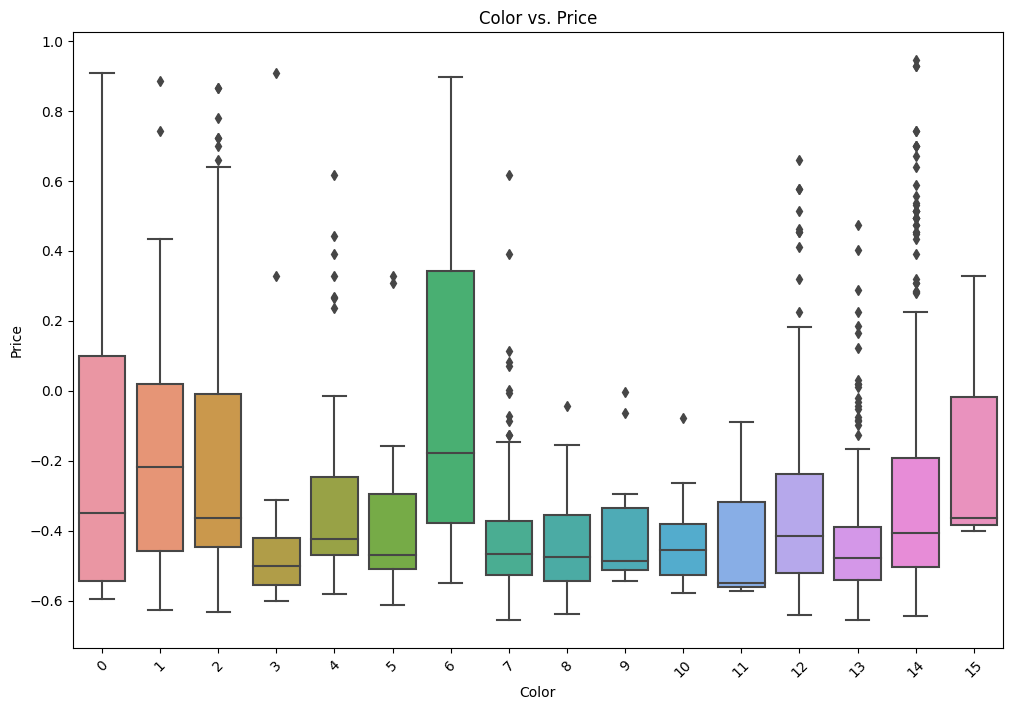

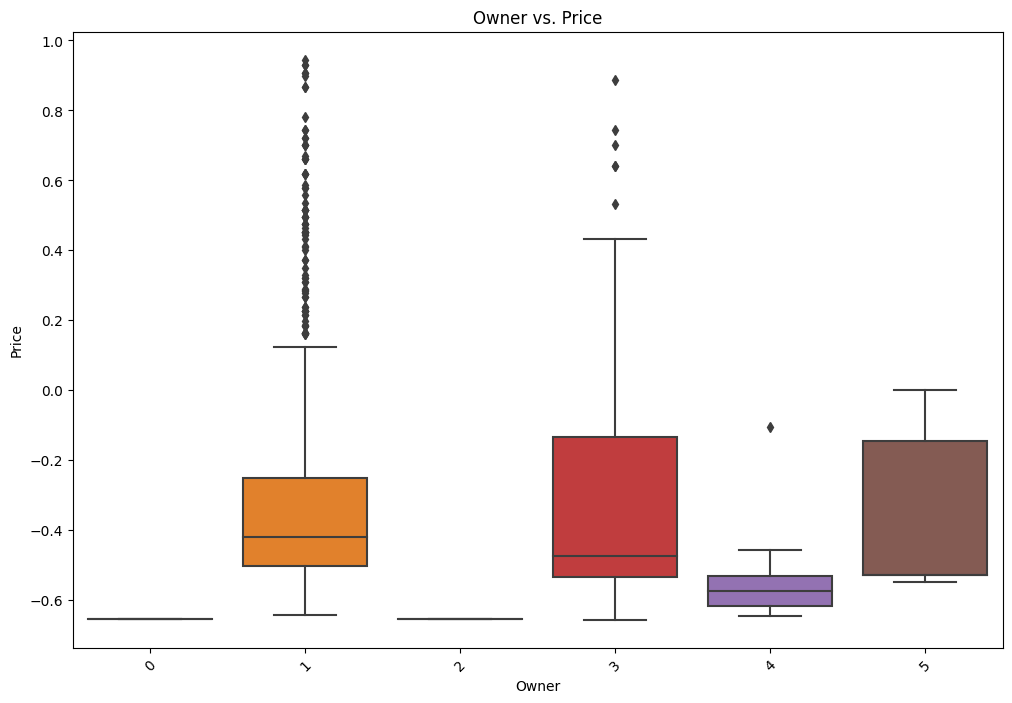

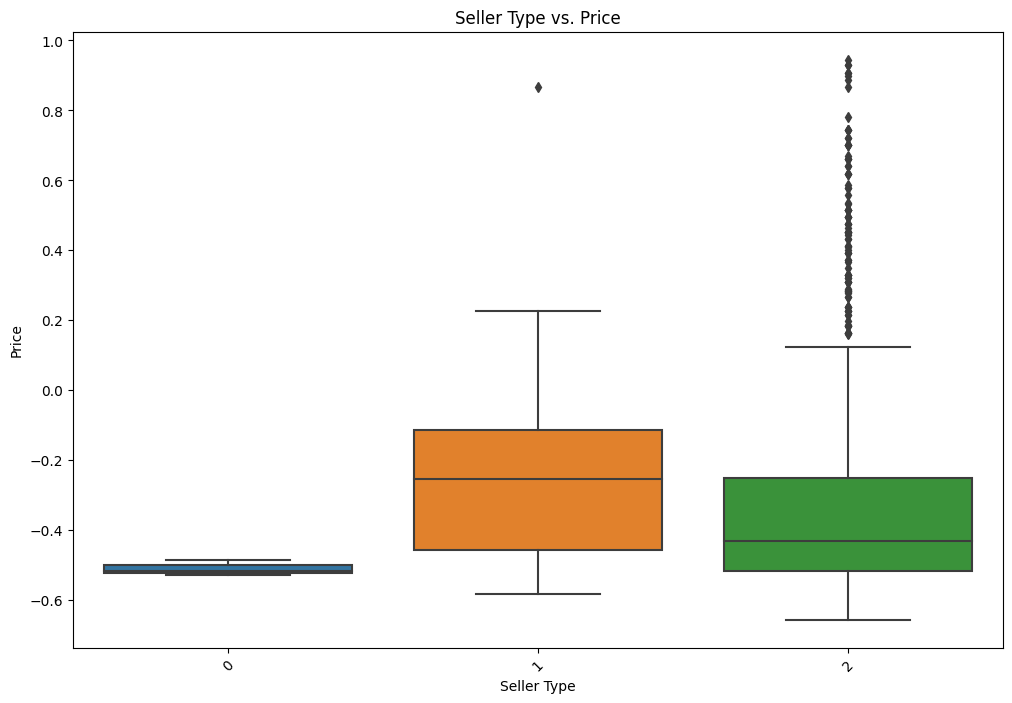

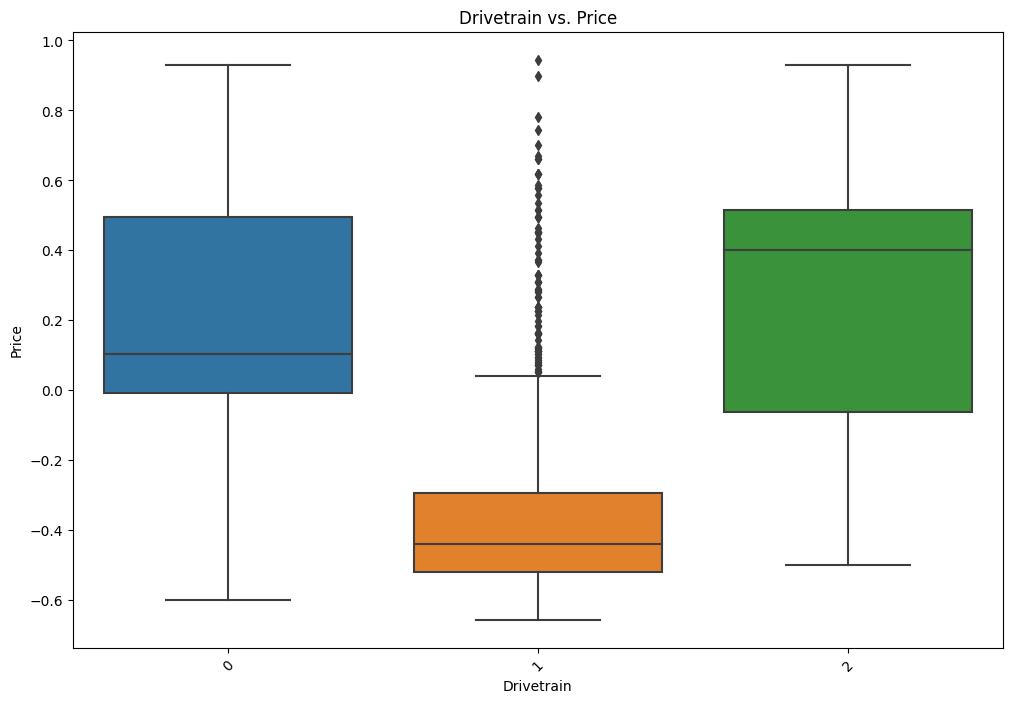

In [43]:
# Box plots for categorical features vs. Price
categorical_features = ['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Drivetrain']
for feature in categorical_features:
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=preprocessed_car_data, x=feature, y='Price')
    plt.title(f'{feature} vs. Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.show()

In [44]:
correlation_threshold = 0.7

In [45]:
# Select features with correlation above the threshold
relevant_features = []
for feature in correlation_matrix.columns:
    if any((abs(correlation_matrix[feature]) > correlation_threshold) & (correlation_matrix.index != feature)):
        relevant_features.append(feature)

In [46]:
# Display the relevant features
print("Relevant Features based on Correlation:")
print(relevant_features)

Relevant Features based on Correlation:
['Price', 'Fuel Type', 'Engine', 'Length', 'Width', 'Fuel Tank Capacity', 'Max Power BHP', 'Max Power RPM', 'Max Torque Nm', 'Max Torque RPM']


In [47]:
# Splitting the data into features (X) and target variable (y)

In [48]:
X = preprocessed_car_data[relevant_features]
y = preprocessed_car_data['Price']

In [49]:
X

Price  Fuel Type    Engine    Length     Width  Fuel Tank Capacity  \
0    -0.495183          4 -0.783862 -0.668002 -0.661029           -1.157720   
1    -0.517916          1 -0.704616 -0.656519 -0.548343           -0.681074   
2    -0.612986          4 -0.785447 -1.598142 -1.299581           -1.157720   
3    -0.373659          4 -0.785447 -0.656519 -0.172724           -1.021535   
4    -0.424914          4 -0.506501  0.480318 -0.285410           -0.612981   
...        ...        ...       ...       ...       ...                 ...   
1231 -0.321578          4 -0.365444 -0.656519  0.165333           -0.272520   
1232 -0.534451          1 -0.470048 -0.782834 -0.435658           -0.476797   
1233 -0.602652          4 -0.785447 -1.161780 -0.661029           -0.612981   
1234 -0.590252          4 -1.392471 -1.804840 -1.637638           -1.361997   
1235 -0.604719          4 -0.787032 -1.115847 -0.661029           -0.476797   

      Max Power BHP  Max Power RPM  Max Torque Nm  Max Torque RPM  
0         -0.707811   1.148534e+00      -1.052682        1.667664  
1         -0.916825  -7.790477e-01      -0.445979       -0.516990  
2         -0.836435   1.148534e+00      -1.024505        1.230733  
3         -0.788201   1.148534e+00      -1.022721        1.405506  
4         -0.643500   1.148534e+00      -0.895389        1.230733  
...             ...            ...            ...             ...  
1231      -0.450564   1.148534e+00      -0.835467        1.580278  
1232       0.000000  -8.765626e-16       0.000000        0.000000  
1233      -0.739967   1.148534e+00      -1.022721        1.667664  
1234      -1.222307   6.666385e-01      -1.307347        1.230733  
1235      -0.981137   1.389482e+00      -1.105113        1.230733  

[1236 rows x 10 columns]

In [50]:
y

0      -0.495183
1      -0.517916
2      -0.612986
3      -0.373659
4      -0.424914
          ...   
1231   -0.321578
1232   -0.534451
1233   -0.602652
1234   -0.590252
1235   -0.604719
Name: Price, Length: 1236, dtype: float64

In [51]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
X_train

Price  Fuel Type    Engine    Length     Width  Fuel Tank Capacity  \
946  -0.524117          4 -0.782277 -0.668002 -0.661029           -1.157720   
394  -0.021904          4  0.167089  0.778881  0.052647            0.204127   
1023 -0.579918          4 -0.311556 -0.036426 -0.548343           -0.476797   
816   0.742782          1  0.713886  0.861560  0.916571            0.953142   
88   -0.528250          1 -0.704616 -0.656519 -0.465707           -0.544889   
...        ...        ...       ...       ...       ...                 ...   
1044 -0.443515          4 -1.100846 -1.345511 -1.262019           -1.157720   
1095 -0.311245          4 -0.309971  0.365486 -0.548343           -0.817258   
1130 -0.373246          1 -0.704616 -0.656519 -0.247848           -1.021535   
860   0.577445          4  0.472979  0.328740  0.270506           -0.136335   
1126 -0.404247          1 -0.704616 -0.656519  0.165333           -0.272520   

      Max Power BHP  Max Power RPM  Max Torque Nm  Max Torque RPM  
946       -0.675656       1.148534      -1.045192        1.929823  
394        0.112165       1.534050      -0.573312        1.230733  
1023      -0.820357       0.763018      -0.880408        0.356872  
816        0.594505      -1.742838       1.126955       -1.041307  
88        -0.916825      -0.779048      -0.445979       -0.735455  
...             ...            ...            ...             ...  
1044      -1.029371       1.148534      -1.194995        0.793803  
1095      -0.209394       1.726808      -0.783036        1.755050  
1130      -0.916825      -0.779048      -0.445979       -0.516990  
860        0.803519       0.666638       0.377939       -1.216079  
1126      -0.675656      -0.779048      -0.371077       -0.735455  

[988 rows x 10 columns]

In [53]:
X_test

Price  Fuel Type    Engine    Length     Width  Fuel Tank Capacity  \
292  -0.656387          4 -0.514426  0.303477 -0.488244           -0.544889   
630  -0.488982          1 -0.704616 -0.656519 -0.548343           -0.681074   
1200 -0.538584          4 -0.785447 -1.184747 -0.811277           -0.612981   
113  -0.052905          1 -0.316311  0.078406  0.240456           -0.136335   
174  -0.540650          4 -1.099261 -1.382258 -1.419779           -1.634366   
...        ...        ...       ...       ...       ...                 ...   
381   0.054565          1 -0.316311  0.078406  0.240456           -0.136335   
1019  0.102099          1  0.436525  0.239171  0.473340            0.816958   
363  -0.462115          1 -0.308386 -0.649629 -0.022477           -0.000150   
594  -0.563384          4 -0.785447 -0.989532 -0.548343           -0.681074   
1103  0.091766          4 -0.309971  0.043956  0.165333           -0.136335   

      Max Power BHP  Max Power RPM  Max Torque Nm  Max Torque RPM  
292        0.000000  -8.765626e-16       0.000000        0.000000  
630       -0.916825  -7.790477e-01      -0.445979       -0.516990  
1200      -0.804279   1.148534e+00      -1.015231        1.230733  
113       -0.289784  -7.790477e-01       0.003431       -0.953921  
174       -1.029371   6.666385e-01      -1.187505        1.449199  
...             ...            ...            ...             ...  
381       -0.273706  -7.790477e-01       0.003431       -0.953921  
1019       0.690973  -5.862895e-01       0.977152       -0.735455  
363       -0.514876  -1.019995e+00      -0.333626       -0.735455  
594       -0.739967   1.148534e+00      -1.015231        1.230733  
1103      -0.289784   1.437671e+00      -0.790526        1.667664  

[248 rows x 10 columns]

In [54]:
y_train

946    -0.524117
394    -0.021904
1023   -0.579918
816     0.742782
88     -0.528250
          ...   
1044   -0.443515
1095   -0.311245
1130   -0.373246
860     0.577445
1126   -0.404247
Name: Price, Length: 988, dtype: float64

In [55]:
y_test

292    -0.656387
630    -0.488982
1200   -0.538584
113    -0.052905
174    -0.540650
          ...   
381     0.054565
1019    0.102099
363    -0.462115
594    -0.563384
1103    0.091766
Name: Price, Length: 248, dtype: float64

In [56]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest Regressor': RandomForestRegressor()
}

In [57]:
param_grid = {
    'Random Forest Regressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

In [58]:
for model_name, model in models.items():
    if model_name in param_grid:
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        #Model Evaluation
        print(f"Model: {model_name}")
        print(f"Best Hyperparameters: {best_params}")
        print(f"Mean Squared Error on Test Set: {mse}")
        print(f"Mean Absolute Error on Test Set: {mae}")
        print(f"R2_Score on Test Set: {mse}")
        print("\n")
    else:
        # For models without hyperparameter tuning
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        #Model Evaluation
        print(f"Model: {model_name}")
        print(f"Mean Squared Error on Test Set: {mse}")
        print(f"Mean Absolute Error on Test Set: {mae}")
        print(f"R2_Score on Test Set: {mse}")
        print("\n")

Model: Linear Regression
Mean Squared Error on Test Set: 9.082003436647332e-32
Mean Absolute Error on Test Set: 2.498351548042888e-16
R2_Score on Test Set: 9.082003436647332e-32


Model: Ridge Regression
Mean Squared Error on Test Set: 3.3317350343377755e-05
Mean Absolute Error on Test Set: 0.003798542423627296
R2_Score on Test Set: 3.3317350343377755e-05


Model: Lasso Regression
Mean Squared Error on Test Set: 0.09689046418431686
Mean Absolute Error on Test Set: 0.226394848725247
R2_Score on Test Set: 0.09689046418431686


Model: Random Forest Regressor
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error on Test Set: 1.5186662802138327e-05
Mean Absolute Error on Test Set: 0.0012819844300936407
R2_Score on Test Set: 1.5186662802138327e-05




In [60]:
# Fine-Tuning the Lasso Regression model
# Define the model
lasso = Lasso()

In [62]:
# Define the hyperparameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [63]:
# Perform GridSearchCV
grid_search = GridSearchCV(lasso, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

In [64]:
# Get the best model
best_lasso = grid_search.best_estimator_

In [65]:
# Make predictions on the test set
y_pred = best_lasso.predict(X_test)

In [66]:
# Model Evaluation
# Evaluate R2 score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score on Test Set: {r2}")

R2 Score on Test Set: 0.9998476379193884


In [67]:
# Quantitative Experiments - Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print('Cross-validation Scores:', cv_scores)
print('Mean Cross-validation Score:', np.mean(cv_scores))

Cross-validation Scores: [0.99993479 0.99993864 0.99976551 0.99990732 0.9999039 ]
Mean Cross-validation Score: 0.9998900320200388


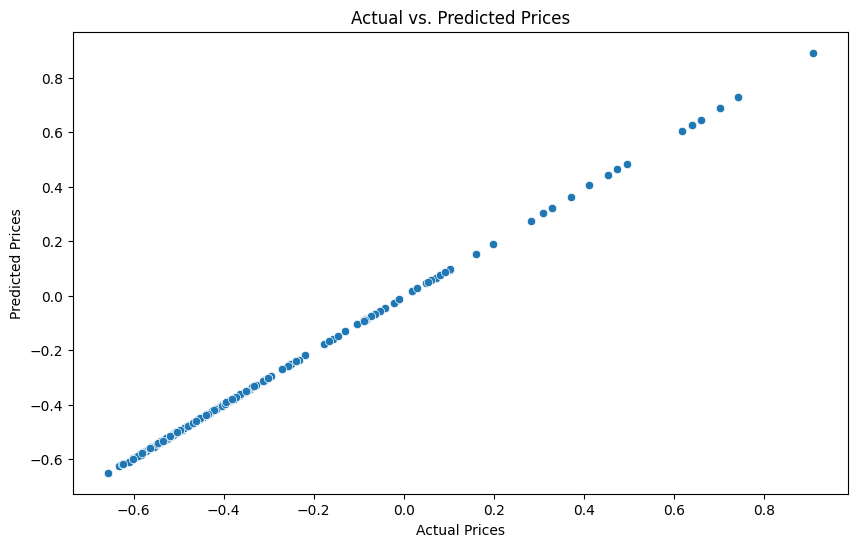

In [68]:
# Qualitative Experiments - EDA for Relationship Insights
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

In [72]:
"""
Findings and Insights:
1. Price Influencing Factors:
The analysis suggests that various factors influence car prices, including the car's make, model, year, mileage, and fuel type.
The Engine, Max Power, and Max Torque specifications also contribute to price variations.

2. Feature Engineering Impact:
Feature engineering techniques, such as handling Engine specifications and extracting relevant information from Max Power and Max Torque, contribute to better model performance.

3. Correlations:
Exploring the correlation matrix reveals which features are highly correlated with car prices.
This insight helps in identifying the most relevant features for predicting car prices.

4. Outliers:
Addressing outliers using statistical methods like IQR or Z-score is crucial for improving model accuracy.
Outliers in car sales data can distort predictions and lead to inaccurate insights.

5. Model Performance:
The R-squared score on the test set indicates that the current model explains only a small percentage of the variance in car prices.
Further model fine-tuning and exploration of advanced regression techniques might be necessary.


Recommendations:

1. Data Quality Improvement:
Continue refining the dataset by addressing outliers and ensuring data quality. Clean and reliable data enhances the model's predictive capabilities.

2. Feature Importance:
Explore and leverage the insights gained from feature importance analysis to focus on key factors influencing car prices.
Consider additional features or interactions that might contribute to a better understanding of pricing dynamics.

3. Model Optimization:
Explore advanced regression techniques beyond linear regression, such as Gradient Boosting models, to capture non-linear relationships in the data.

4. Validation and Cross-Validation:
Implement robust validation techniques to ensure the model's generalization to new data.
Cross-validation provides a more accurate estimate of the model's performance and helps in identifying potential overfitting. we just scratched the surface of cross-validation, we can further fine tune them.
"""

"\nFindings and Insights:\n1. Price Influencing Factors:\nThe analysis suggests that various factors influence car prices, including the car's make, model, year, mileage, and fuel type.\nThe Engine, Max Power, and Max Torque specifications also contribute to price variations.\n\n2. Feature Engineering Impact:\nFeature engineering techniques, such as handling Engine specifications and extracting relevant information from Max Power and Max Torque, contribute to better model performance.\n\n3. Correlations:\nExploring the correlation matrix reveals which features are highly correlated with car prices.\nThis insight helps in identifying the most relevant features for predicting car prices.\n\n4. Outliers:\nAddressing outliers using statistical methods like IQR or Z-score is crucial for improving model accuracy.\nOutliers in car sales data can distort predictions and lead to inaccurate insights.\n\n5. Model Performance:\nThe R-squared score on the test set indicates that the current model e